# Analysing the seasonality of google search for domains

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
from glob import glob
from statsmodels.tsa.seasonal import seasonal_decompose

import xavy.plots as xp

## Functions

In [2]:
def load_trends(filename):
    
    df = pd.read_csv(filename, skiprows=1).set_index('Week')
    newnames = [s.split(':')[0] for s in df.columns]
    mapper = dict(zip(df.columns, newnames))
    df.rename(mapper, axis=1, inplace=True)
    
    return df

In [3]:
def ts_min(series):
    return series.index.min()

def ts_max(series):
    return series.index.max()

def plot_component(series, xmin, xmax):
    pl.plot(series)
    pl.xlim([xmin, xmax])
    pl.grid(axis='x')

def plot_decomp(season_model, n_cols=1, col=1):
    
    xmin = min([ts_min(season_model.trend), ts_min(season_model.seasonal), ts_min(season_model.resid)])
    xmax = max([ts_max(season_model.trend), ts_max(season_model.seasonal), ts_max(season_model.resid)])

    pl.subplot(3, n_cols, int(0 * n_cols + col))
    plot_component(season_model.trend, xmin, xmax)
    pl.subplot(3, n_cols, int(1 * n_cols + col))
    plot_component(season_model.seasonal, xmin, xmax)
    pl.subplot(3, n_cols, int(2 * n_cols + col))
    plot_component(season_model.resid, xmin, xmax)

In [4]:
def frac_seasonal(series):

    season_model = seasonal_decompose(series, model='additive')
    avg = series.mean()
    frac_season = season_model.seasonal / avg
    
    return frac_season

In [5]:
def three_month_frac_seasonal(series):

    # Compute seasonal fractional variation:
    fts = frac_seasonal(series)

    # Sanity check:
    intervals = (fts.index[1:] - fts.index[:-1]).unique()
    assert len(intervals) == 1
    assert intervals[0] == pd.Timedelta('7 days 00:00:00')

    # Compute interval size:
    days_in_month = np.mean([31,28.25,31,30,31,30,31,31,30,31,30,31])
    weeks_in_month = days_in_month / 7
    n_weeks_3_months = int(np.round(weeks_in_month * 3)) 

    # Average
    var_3_months = fts.rolling(n_weeks_3_months, center=True).mean()
    
    return var_3_months

## Load data

In [6]:
data_files = glob('../data/raw/google-trends/*.csv')

In [7]:
df = pd.concat([load_trends(f) for f in data_files], axis=1)
df.index = pd.to_datetime(df.index)

In [8]:
df

,taobao,bilibili,instagram,netflix,wikipedia,github,pinduoduo,office365,facebook,walmart,live,xvideos,accuweather,espn,weather,youtube,aliexpress,amazon
Week,,,,,,,,,,,,,,,,,,
2019-08-25,69,8,81,44,84,37,9,55,99,50,37,92,99,83,56,91,72,64
2019-09-01,68,7,82,45,89,36,9,58,93,48,40,97,100,100,53,94,63,60
2019-09-08,72,7,85,43,87,39,8,62,95,44,35,94,94,94,46,91,64,62
2019-09-15,64,7,79,45,86,39,8,60,95,45,39,91,82,82,44,90,63,62
2019-09-22,69,7,81,43,90,39,7,61,90,41,36,98,88,80,49,86,72,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-28,41,71,76,39,58,88,48,19,39,35,36,63,62,35,68,73,44,54
2024-08-04,44,70,77,39,59,86,52,19,38,35,38,59,58,35,66,70,46,56
2024-08-11,46,74,78,43,58,88,56,18,40,35,30,64,56,36,62,75,48,57


## Compare time series

### Weather

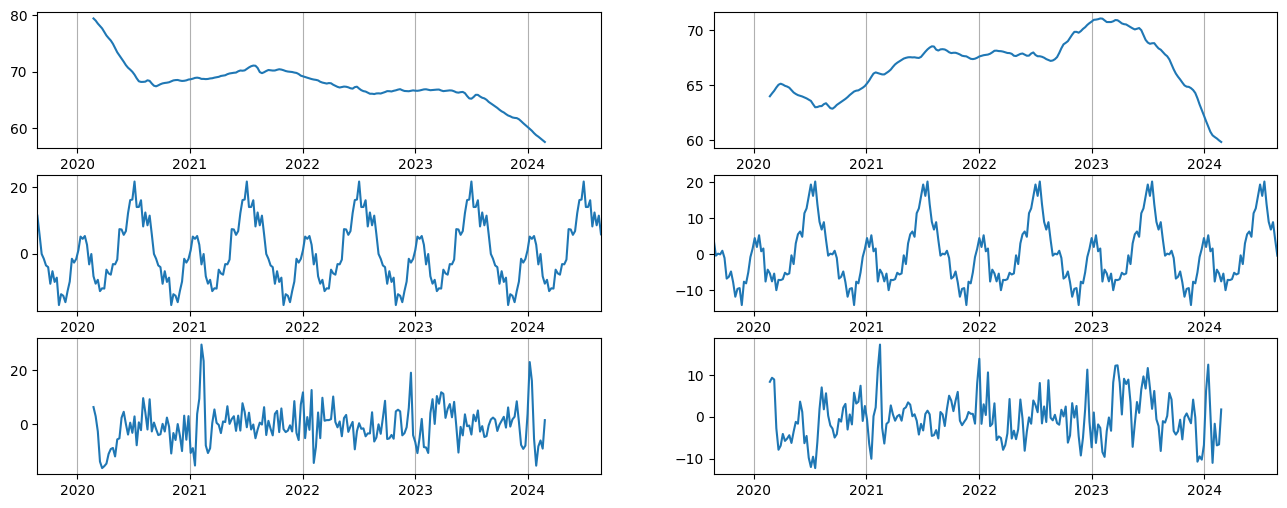

In [9]:
pl.figure(figsize=(16,6))
season_model = seasonal_decompose(df['accuweather'], model='additive')
plot_decomp(season_model, 2, 1)
season_model = seasonal_decompose(df['weather'], model='additive')
plot_decomp(season_model, 2, 2)

### Western E-commerce

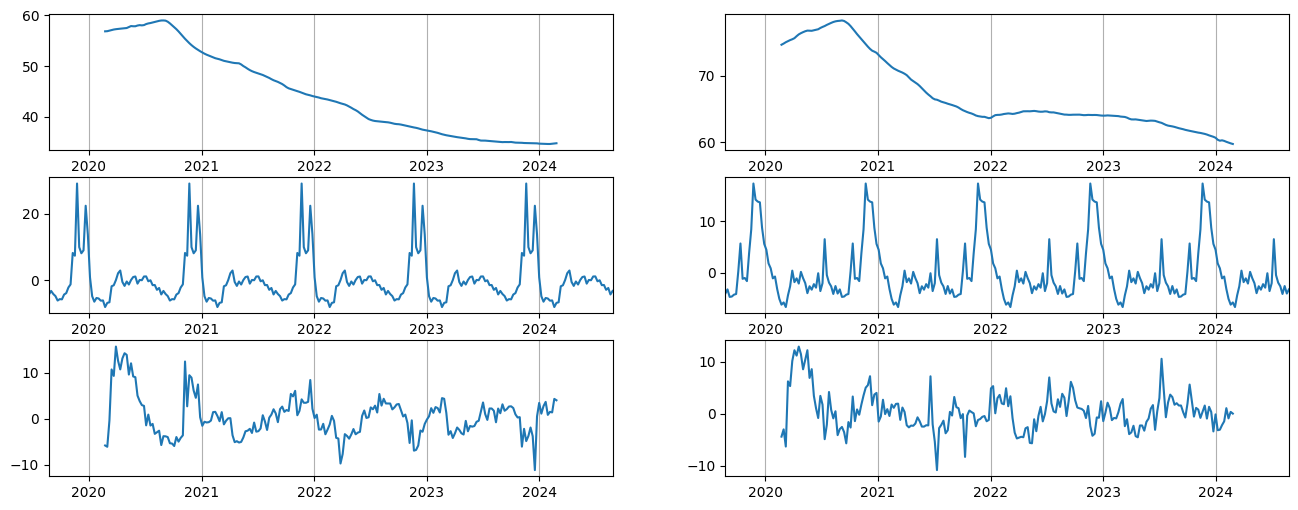

In [18]:
pl.figure(figsize=(16,6))
season_model = seasonal_decompose(df['walmart'], model='additive')
plot_decomp(season_model, 2, 1)
season_model = seasonal_decompose(df['amazon'], model='additive')
plot_decomp(season_model, 2, 2)

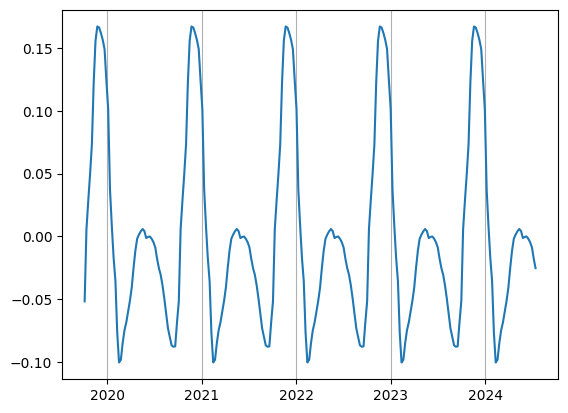

In [14]:
pl.plot(three_month_frac_seasonal(df['walmart']))
pl.grid(axis='x')
pl.show()

### Chinese E-commerce

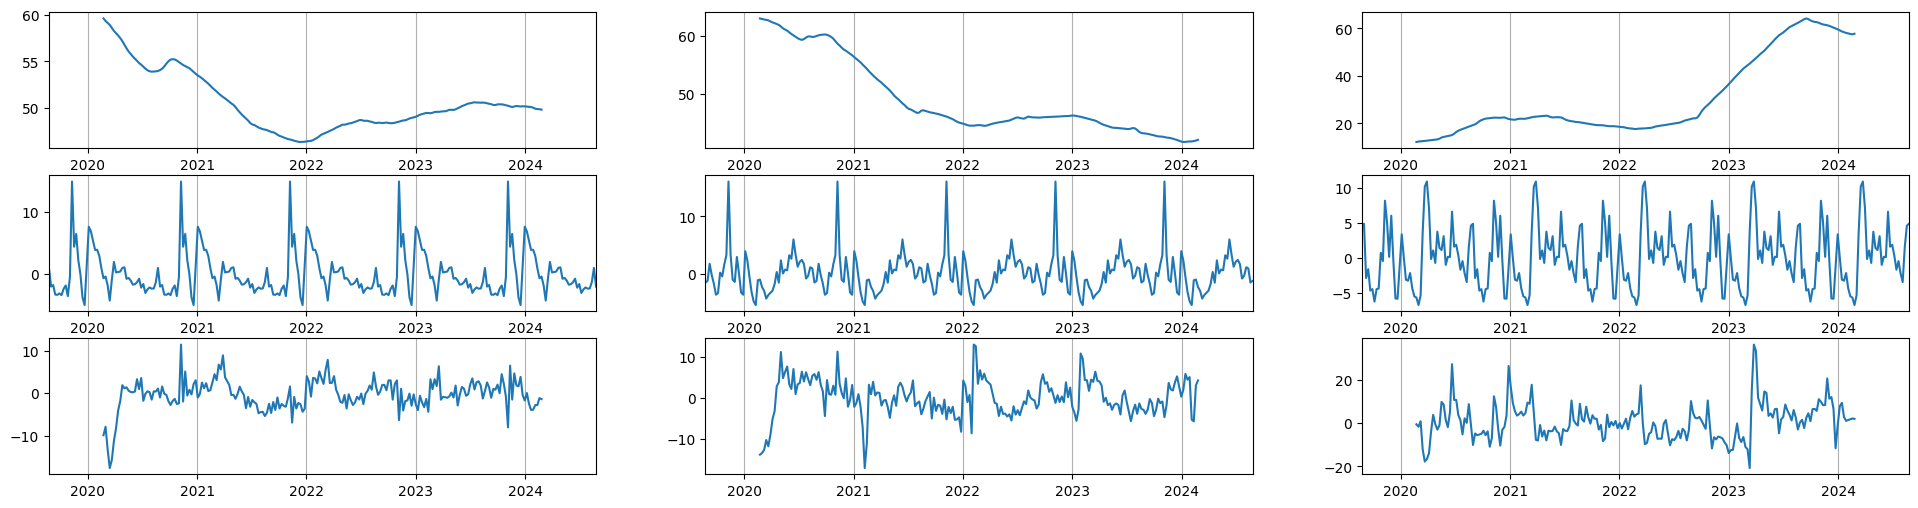

In [19]:
pl.figure(figsize=(24,6))
season_model = seasonal_decompose(df['aliexpress'], model='additive')
plot_decomp(season_model, 3, 1)
season_model = seasonal_decompose(df['taobao'], model='additive')
plot_decomp(season_model, 3, 2)
season_model = seasonal_decompose(df['pinduoduo'], model='additive')
plot_decomp(season_model, 3, 3)

### Streaming

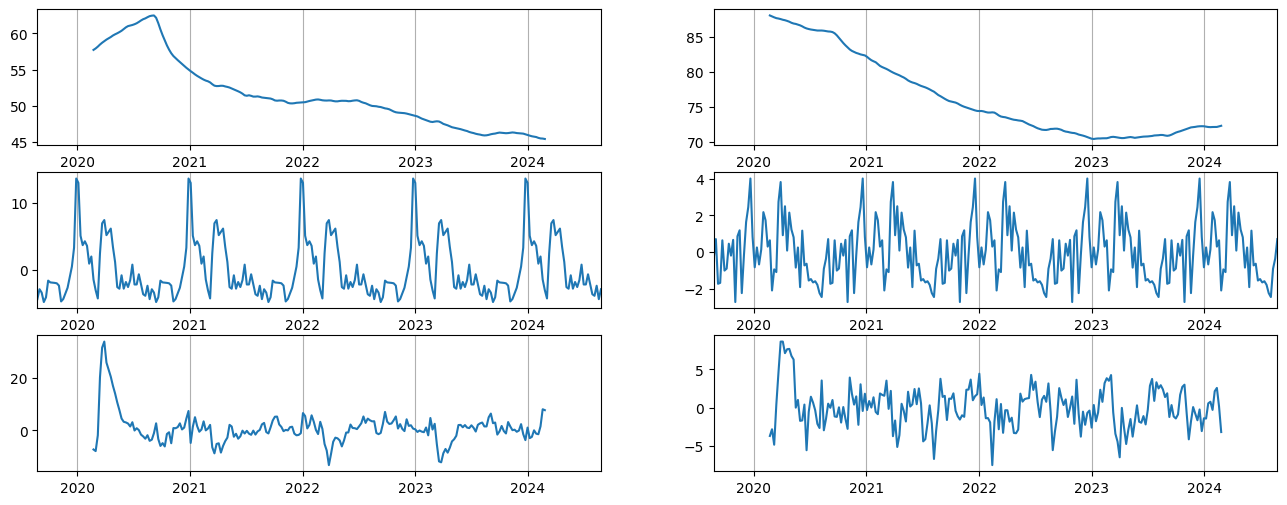

In [20]:
pl.figure(figsize=(16,6))
season_model = seasonal_decompose(df['netflix'], model='additive')
plot_decomp(season_model, 2, 1)
season_model = seasonal_decompose(df['youtube'], model='additive')
plot_decomp(season_model, 2, 2)

### Work

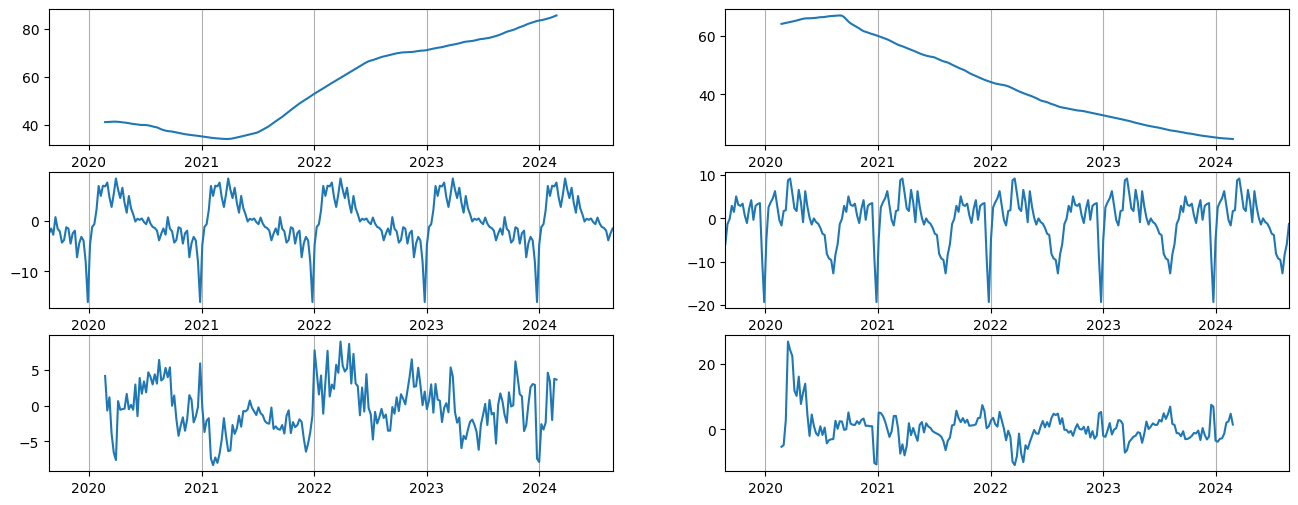

In [21]:
pl.figure(figsize=(16,6))
season_model = seasonal_decompose(df['github'], model='additive')
plot_decomp(season_model, 2, 1)
season_model = seasonal_decompose(df['office365'], model='additive')
plot_decomp(season_model, 2, 2)

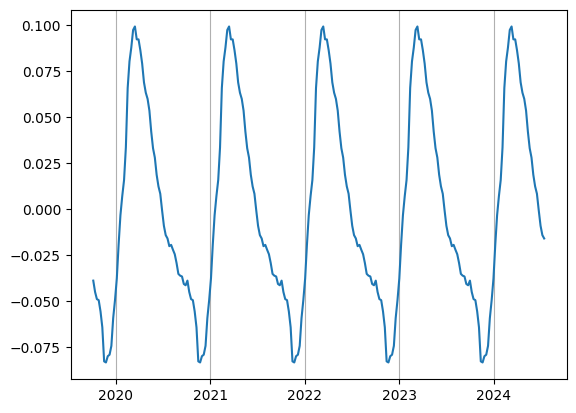

In [16]:
pl.plot(three_month_frac_seasonal(df['github']))
pl.grid(axis='x')
pl.show()

### Social media

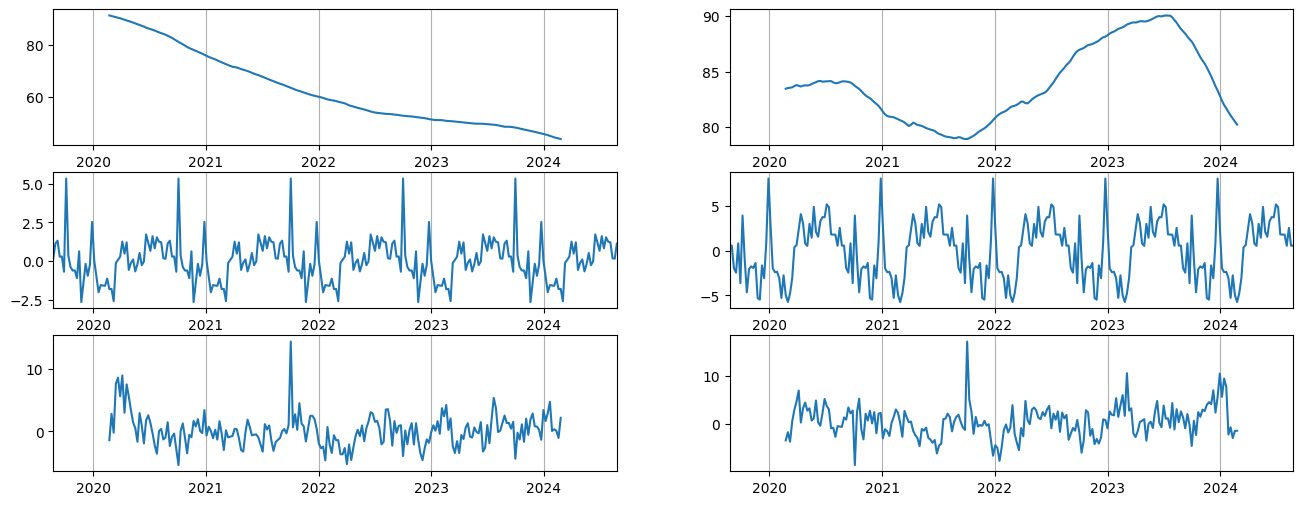

In [22]:
pl.figure(figsize=(16,6))
season_model = seasonal_decompose(df['facebook'], model='additive')
plot_decomp(season_model, 2, 1)
season_model = seasonal_decompose(df['instagram'], model='additive')
plot_decomp(season_model, 2, 2)

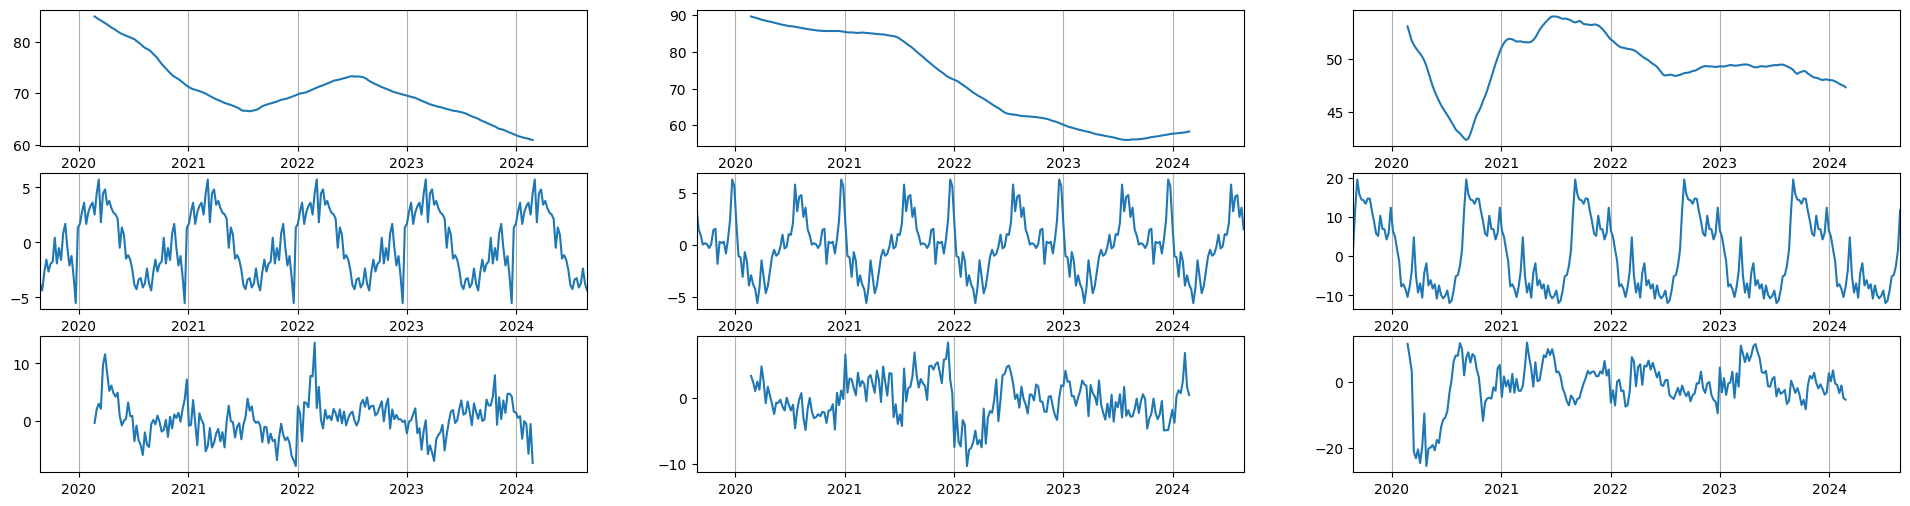

In [29]:
pl.figure(figsize=(24,6))
season_model = seasonal_decompose(df['wikipedia'], model='additive')
plot_decomp(season_model, 3, 1)
season_model = seasonal_decompose(df['xvideos'], model='additive')
plot_decomp(season_model, 3, 2)
season_model = seasonal_decompose(df['espn'], model='additive')
plot_decomp(season_model, 3, 3)

## Estimating average variability

In [23]:
pd.Series([three_month_frac_seasonal(df[domain]).abs().max() for domain in df.columns], index=df.columns).sort_values(ascending=False)

espn           0.243109
accuweather    0.184479
weather        0.177589
walmart        0.167326
live           0.148997
office365      0.117241
pinduoduo      0.113389
amazon         0.105598
github         0.099155
bilibili       0.086342
aliexpress     0.071565
netflix        0.070429
taobao         0.059130
wikipedia      0.050398
xvideos        0.045485
instagram      0.036600
facebook       0.018082
youtube        0.017322
dtype: float64